# Plan de Trabajo:

Para este proyecto implementaremos los siguientes pasos:

1. Carga de información y Exploración de la estructura de datos.
Este proceso es fundamental, a traves de investigar cada libro/base de datos entenderemos la estructura y como aterrizar las ideas.

2. Exploración de los datos:
Al trabajar para la gente que toma las decisiones, Trataremos de sacar datos relevantes, que podran darle forma al fenomeno.

***“Lo que no se define no se puede medir. Lo que no se mide, no se puede mejorar. Lo que no se mejora, se degrada siempre.”***

-  William Thomson Kelvin

3. Prepararemos los datos para el modelo.
Al trabajar em modelos, debemos transformar las variables categoricas por variables dicotomicas o escaladas.

4. Generaremos modelos:
Que nos ayuden a comprende aquello que pudiera estar fallando.

5. Recopilaremso resultados y Generaremos un informe.




# Interconnect: Retención de Clientes.

Para interconnect nuestro clientes son nuestra principal fuente de ingresos, y su retención es la clave para que nuestra empresa mejore y prospere.

Por ello, implementaremos diversas medidas de retención de los mismos.

***Estrategia:***
***Si algun usuario quiere cancelar su plan se le ofrecerán códigos promocionales y opciones de planes especiales.***

Este modelo, plantea dar solución a este aspecto y buscar predecir en base al comportamiento del cliente.

El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

------------------------------------------------------------------------------------------------------------------------------------

## Servicios de Interconnect

-----------------------------------------------------
Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.


-------------------------------------------------------------------------------------------------------------------------------------

# Documentación:

-------------------------------

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;

|Campos|Descripción|Tipo|
|------|-----------|----|
|customerID| Id del cliente|Alfanumerico(Str)|
|BeginDate|Fecha de inicio del servicio|Fecha(DAte)|
|EndDate|Fecha de baja de servicio|Fecha(Date)|
|Type|Tipo de contrato.|Cadena(Str)|
|PaperlessBilling|Factura física|Dicotomica(Yes - Digital, No - Electronica)|
|PaymentMethod|Metodo de Pago|Cadena(Str)|
|MonthlyCharges|Cargos Mensuales|Númerica(Float64)|
|TotalCharges|Cargos Totales|Númerica(Float64)|

- `personal.csv` — datos personales del cliente;

|Campos|Descripción|Tipo|
|------|-----------|----|
|customerID| Id del Cliente| Alfanumerico(Str)|
|gender|Genero del cliente|Cadena(Str)|
|SeniorCitizen|Cuidadano|(Binaria 1 - Si, 0 - No)|
|Partner|Socio|Cadena(Str), Yes, No|
|Dependents|Si tiene dependientes o no|Cadena(Str),Yes, No|

- `internet.csv` — información sobre los servicios de Internet;

|Campos|Descripción|Tipo|
|------|-----------|----|
|customerID|Id del Cliente| Alfanumerico(Str)|
|InternetService|si se le proporciona Servicio de internet|Cadena(Str)|
|OnlineSecurity|Cuenta con el servicio de seguridad|Dicotomica(Yes, No)|
|OnlineBackup|Tiene el servicio de nube |Dicotomica(Yes, No)|
|DeviceProtection|Cuenta con protección para sus dispositivos|Dicotomica(Yes, No)|
|TechSupport|Tiene soporte sobre tecnología|Dicotomica(Yes, No)|
|StreamingTV|Tiene el servicio de Streaming|Dicotomica(Yes, No)|
|StreamingMovies|Cuenta con el servicio de Streaming de peliculas|Dicotomica(Yes, No)|


- `phone.csv` — información sobre los servicios telefónicos.

|Campos|Descripción|Tipo|
|------|-----------|----|
|customerID|Id del Cliente| Alfanumerico(Str)|
|MultipleLines|Si tiene muchas lineas o solo cuenta con una|Dicotomica(Yes, No)|


En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.


## Carga de Librerias:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


## Carga de Información:

In [27]:
contratos = pd.read_csv("contract.csv")
personal = pd.read_csv("personal.csv")
internet = pd.read_csv("internet.csv")
telefono= pd.read_csv("phone.csv")

## Estandarización de Campos:

dadas las buenas practicas generamos una función que mande a minusculas los nombres, quite espacios y si hay necesidad indroduzca un guion bajo entre las palabras.

In [28]:
def estandarizar_nombres_columnas(df):
    df.columns = (
        df.columns
        .str.strip()  # Eliminar espacios al inicio y al final
        .str.lower()  # Convertir a minúsculas
        .str.replace(r'\s+', '_', regex=True)  # Reemplazar espacios múltiples por un solo guion bajo
        .str.replace(r'[^\w]', '', regex=True)  # Eliminar caracteres especiales
    )
    return df

### Duplicados y datos faltantes:


In [29]:
def limpiar_dataframe(df, metodo_faltantes='drop', subset_columnas=None):
    # Eliminar duplicados
    df = df.drop_duplicates(subset=subset_columnas)
    
    # Manejo de datos faltantes
    if metodo_faltantes == 'drop':
        df = df.dropna()  # Elimina filas con valores faltantes
    elif metodo_faltantes == 'fill':
        for col in df.select_dtypes(include=['number']).columns:
            df[col] = df[col].fillna(df[col].mean())  # Rellena numéricos con la media
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].fillna(df[col].mode()[0])  # Rellena categóricos con la moda

    return df

In [30]:
contratos = limpiar_dataframe(contratos, metodo_faltantes="drop")
personal = limpiar_dataframe(personal, metodo_faltantes="drop")
internet = limpiar_dataframe(internet, metodo_faltantes="drop")
telefono = limpiar_dataframe(telefono, metodo_faltantes="drop")

## Unión de Bases:
Concentrar la información y tener el panorama completo podra mostrar los comportamientos y señales que nos ayudaran a prevenir la perdida de clientes.

***Usamos el metodo outer para la union completa de los dataframe y encontrar que si faltan datos estos podrian estar relacionados con la falta de servición o podrian marcar alguna pauta para que el cliente se decida a terminar la relación comercial.*** 

In [31]:
df_u1 = pd.merge(personal, contratos, on="customerID", how="outer")
df_u2 = pd.merge(df_u1, internet, on="customerID", how="outer")
df_u3 = pd.merge(df_u2, telefono, on="customerID", how="outer")
df_u3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           7043 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


## Corrección de Tipos de datos:
Antes de codificar la información es importante checar los tipos y por ende lograr que la información tenga cuerencia y podamos estandarizar los campos, para el caso de las fechas el valor nulo, el valor nulo a usar sera: **01/01/1900**, para darle cuerencia, aunque esta columan al momento de generar la infomración para entrenar el modelo tendra a desaparecer.

Para los servicios en los cuales no se presenta el registro suponemos que no se cuenta con el mismo por lo que se creara la etiqueta de **"no contratado"** y se pondra en **"0"** aquello, y para los servicios de telefonia fija, se pondra como no todos aquellos refistros faltantes con ello buscamos contar con la mayor cantidad de información. 



In [32]:
#print(df_u3["EndDate"].unique())
#print(df_u3["BeginDate"].unique())
#print(df_u3["InternetService"].unique())
df_u3["TotalCharges"] = pd.to_numeric(df_u3["TotalCharges"], errors='coerce')
print(df_u3["TotalCharges"].unique())


[ 593.3   542.4   280.85 ...  742.9  4627.65 3707.6 ]


In [33]:
df_u3["abandono"] = (df_u3["EndDate"] != 'No').astype(int)
df_u3["fecha_inicio"] = pd.to_datetime(df_u3["BeginDate"]).astype(int) / 10**9
df_u3["InternetService"] = df_u3["InternetService"].fillna("No_service")
df_u3.fillna("No", inplace=True)
#df_u3.drop(columns=["BeginDate", "EndDate"], inplace=True)
df_u3 = estandarizar_nombres_columnas(df_u3)
df_u3["totalcharges"] = pd.to_numeric(df_u3["totalcharges"], errors='coerce')

df_u3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   begindate         7043 non-null   object 
 6   enddate           7043 non-null   object 
 7   type              7043 non-null   object 
 8   paperlessbilling  7043 non-null   object 
 9   paymentmethod     7043 non-null   object 
 10  monthlycharges    7043 non-null   float64
 11  totalcharges      7032 non-null   float64
 12  internetservice   7043 non-null   object 
 13  onlinesecurity    7043 non-null   object 
 14  onlinebackup      7043 non-null   object 
 15  deviceprotection  7043 non-null   object 
 16  techsupport       7043 non-null   object 


C:\Users\utril\AppData\Local\Temp\ipykernel_24860\3496434923.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_u3.fillna("No", inplace=True)


## Análisis Exploratorio de Datos:

## Abandono:
Observar el abandono, por parte de nuestros clientes es vital para entener el fenomeno y por que se genera.

### Totales:
Observaremos la proporcion de la muestra para blaancear la muestra.

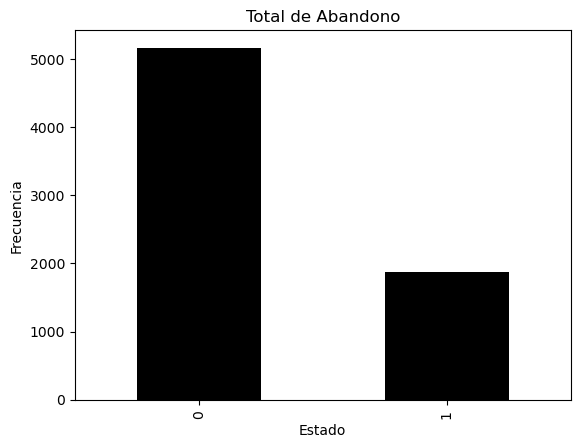

Desbalance de casos:1869(26.58%)


In [34]:
total_abandono = df_u3.groupby(by = "abandono")["totalcharges"].count()
total_abandono.plot(title = "Total de Abandono",xlabel = "Estado", ylabel = "Frecuencia", kind = "bar", color = "black"  )
plt.show()
print(f"Desbalance de casos:{total_abandono[1]}({total_abandono[1]/(total_abandono[1]+total_abandono[0]):.2%})")

#### Hallazgo 01:
Encontramos que el abandono por parte de los clientes es del 26.58%, un cuarto de nuestros contratos.

### Ingreso por clientes que Abandonaron:
Lo importante observar los ingresos por cliente que nos abandonan y el por que, ya que una señal podria ser que nuestros clientes más fuertes nos 

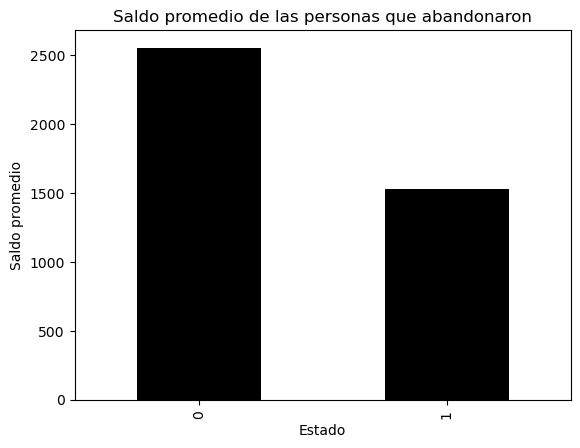

Ingreso promedio perdido:$1531.80


In [35]:
saldo_abandono = df_u3.groupby(by = "abandono")["totalcharges"].mean()
saldo_abandono.plot(title ="Saldo promedio de las personas que abandonaron", xlabel = "Estado", ylabel = "Saldo promedio", kind = "bar", color = "black")
plt.show()
print(f"Ingreso promedio perdido:${saldo_abandono[1]:.2f}")

#### Hallazgo 02:
Podemos observar que entre las personas que abnadonaron nuestros servicios, el monto promedio no fue tan significativo, tenemos clientes que se mantienen con nosostros a psear de que su cuenta rebasa los $2,500.00, tendremos a observar otros aspectos.

### Fechas de Abandono:

Revisar el record de fechas y las tasas de abandono nos ayudara a entender su abandono o vislumbrar si en esas fechas ocurrio algun fenomeno que nos pudiera ayudar entender mejor el fenomeno.

In [36]:
fechas_adandono = df_u3.groupby(by = "enddate")["totalcharges"].count()
print(fechas_adandono)

enddate
2019-10-01 00:00:00     458
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
No                     5163
Name: totalcharges, dtype: int64


#### Hallazgo 03:
Encontramos que el ultimo trimestre del 2019, tendriamos que checar a detalle los aspectos que gnereron el abandono por parte de nuestros clientes.

### Planes que presentan abandono:
Encontrar los planes que presentan mayor indice de abandono podria ser la calve, para reevaluar los mismo.

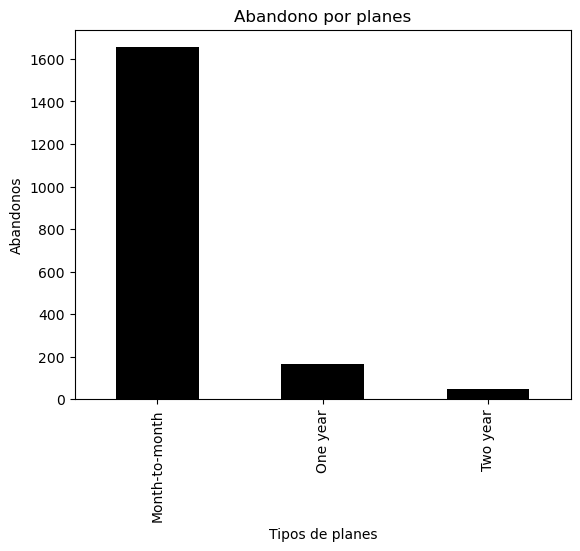

type
Month-to-month    1655
One year           166
Two year            48
Name: totalcharges, dtype: int64


In [37]:

planes_abandono = df_u3[df_u3["abandono"] == 1]
planes_abandonos = planes_abandono.groupby(by = "type")["totalcharges"].count()
planes_abandonos.plot(title = "Abandono por planes", xlabel = "Tipos de planes", ylabel = "Abandonos", kind = "bar", color = "black")
plt.show()

print(planes_abandonos)

#### Hallazgo 04:
Encontramos que la mayor parte de los abandono se encuentran en el plan mes a mes, tendremos que checar si se ha implementado algun plan a menos costo por la competencia o si se refiere ha algun tema interno con el servicio.

### Preparación de datos para la regresión:
Preparar la información para la regresión. 

In [38]:
# Columnas simples:
df_regresion = df_u3

df_regresion["gender"] = df_regresion["gender"].map({"Female": 1, "Male": 0})
df_regresion["partner"] = df_regresion["partner"].map({"Yes": 1, "No": 0})
df_regresion["dependents"] = df_regresion["dependents"].map({"Yes": 1, "No": 0})
df_regresion["paperlessbilling"] = df_regresion["paperlessbilling"].map({"Yes": 1, "No": 0})
df_regresion["onlinesecurity"] = df_regresion["onlinesecurity"].map({"Yes": 1, "No": 0})
df_regresion["onlinebackup"] = df_regresion["onlinebackup"].map({"Yes": 1, "No": 0})
df_regresion["deviceprotection"] = df_regresion["deviceprotection"].map({"Yes": 1, "No": 0})
df_regresion["techsupport"] = df_regresion["techsupport"].map({"Yes": 1, "No": 0})
df_regresion["streamingtv"] = df_regresion["streamingtv"].map({"Yes": 1, "No": 0})
df_regresion["streamingmovies"] = df_regresion["streamingmovies"].map({"Yes": 1, "No": 0})
df_regresion["multiplelines"] = df_regresion["multiplelines"].map({"Yes": 1, "No": 0})

df_regresion.drop(columns=["customerid","begindate", "enddate"], inplace=True)
print(df_regresion.sample(3))


      gender  seniorcitizen  partner  dependents            type  \
4698       0              0        0           0  Month-to-month   
6683       1              0        1           0        Two year   
1999       0              0        1           1        Two year   

      paperlessbilling              paymentmethod  monthlycharges  \
4698                 0               Mailed check           20.35   
6683                 0  Bank transfer (automatic)           64.75   
1999                 0  Bank transfer (automatic)           86.90   

      totalcharges internetservice  onlinesecurity  onlinebackup  \
4698         92.75      No_service               0             0   
6683       4804.75             DSL               1             1   
1999       6194.10             DSL               1             0   

      deviceprotection  techsupport  streamingtv  streamingmovies  \
4698                 0            0            0                0   
6683                 0            1    

In [39]:
# Crear un OneHotEncoder independiente para cada columna
encoder_type = OneHotEncoder(sparse_output=False, drop='first')
encoder_paymentmethod = OneHotEncoder(sparse_output=False, drop='first')
encoder_internetservice = OneHotEncoder(sparse_output=False, drop='first')

# Aplicar OneHotEncoder a cada columna
encoded_type = encoder_type.fit_transform(df_regresion[['type']])
encoded_paymentmethod = encoder_paymentmethod.fit_transform(df_regresion[['paymentmethod']])
encoded_internetservice = encoder_internetservice.fit_transform(df_regresion[['internetservice']])

# Convertir a DataFrame con nombres correctos
df_encoded_type = pd.DataFrame(encoded_type, columns=encoder_type.get_feature_names_out(['type']))
df_encoded_paymentmethod = pd.DataFrame(encoded_paymentmethod, columns=encoder_paymentmethod.get_feature_names_out(['paymentmethod']))
df_encoded_internetservice = pd.DataFrame(encoded_internetservice, columns=encoder_internetservice.get_feature_names_out(['internetservice']))

# Concatenar todas las columnas codificadas con el DataFrame original (sin las columnas originales)
df_regresion_final = pd.concat([df_regresion, df_encoded_type, df_encoded_paymentmethod, df_encoded_internetservice], axis=1)
df_regresion_final.drop(columns=['type', 'paymentmethod', 'internetservice'], inplace=True)


## Generacíon del modelo:

### Gradient Boosting:  

In [40]:
X = df_regresion_final.drop(columns=["abandono"])
y = df_regresion_final["abandono"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=12345)

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("AUC-ROC:", roc_auc_score(y_test, y_prob))
print("Exactitud:", accuracy_score(y_test, y_pred))

c:\Users\utril\anaconda3\envs\cienciadedatos\lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:43] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC-ROC: 0.9375974870251665
Exactitud: 0.9045161290322581


### Red Neuronal:

In [42]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

y_prob_nn = model.predict(X_test).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

print("AUC-ROC:", roc_auc_score(y_test, y_prob_nn))
print("Exactitud:", accuracy_score(y_test, y_pred_nn))

Epoch 1/20


c:\Users\utril\anaconda3\envs\cienciadedatos\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7117 - loss: 790460.7500 - val_accuracy: 0.7400 - val_loss: 0.6283
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7364 - loss: 0.6197 - val_accuracy: 0.7400 - val_loss: 0.5949
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7277 - loss: 0.5984 - val_accuracy: 0.7400 - val_loss: 0.5809
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7326 - loss: 0.5851 - val_accuracy: 0.7400 - val_loss: 0.5757
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7259 - loss: 0.5879 - val_accuracy: 0.7400 - val_loss: 0.5741
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7347 - loss: 0.5790 - val_accuracy: 0.7400 - val_loss: 0.5735
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7312 - loss: 0.5821 - val_accuracy: 0.7400 - val_loss: 0.5733
Epoch 8/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7291 - loss: 0.5842 - val_accuracy: 0.7400 -

---------------------------
## Metricas de evaluación:
---------------------------

Característica objetivo: la columna `'EndDate'` es igual a `'No'`.

Métrica principal: AUC-ROC.

Métrica adicional: exactitud.

Criterios de evaluación:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## Revisión de Modelo:

[X] ¿Realizaste todos los pasos?

[X] ¿La solución coincide con la condición de la tarea?

[X] ¿Entrenaste y probaste correctamente el modelo?

[X] ¿Cuál es la puntuación de calidad del mejor modelo?

[X] ¿Mantuviste la estructura del proyecto?

[X] ¿Mantuviste el código limpio?

### Conclusión:

Los aprendizajes de este proyecto fueron:

1. Recordar la carga de información: 
Se cargo la información de los recutrsos obtenidos.
2. Limpieza de datos y análisis de los mismos.
Se reviso la duplicidad, y los datos faltantes en base a la estructura de los datos se relleno los faltantes.
3. Análisis exploratorio de los datos.
Se conocieron los datos y en base a ellos se tomaron las decisiones y se sacaron señales para la exploración de las variables. 
4.  Se Generaron 2 modelos, uno por gradiante y otro por redes neuronales.

|Modelo|AUC-ROC|Precisión|
|------|-------|---------|
|**Gradiante**| **0.9376**|**0.9045**|
|Red Neuronal|0.5|0.74|

Por lo que superamos el criterio de evaluación del modelo que requeria AUC-ROC ≥ 0.88, se seguiras observando la red neuronal en busca de mayor comprensión, por lo que pude entender se debe al desbalance de clases, por lo que se podria optar por el balance de la muestra.

# Informe de Solución:

A través de este proyecto y como se abordaron los datos, encontramos insights interesantes y un modelo que se ajusta a los requerimientos, siguiento el principio de la **Navaja de Ockham***, se optaron por 2 modelos.

A continuación se detallan los descubrimientos y Se abre a las sugerencias:

1.El abandono impacto en 1869 contratos, significando un  26.58% de nuestros contratos.
2.El ingreso promedio de los contratos Acendio a $1531.80.
3.La cancelación de contratos se centro en el ultimo trimestre del 2019.
4. El plan que presento mayor indice de abandono era el de mes a mes.

se probaron2 modelos, un gradiante y una red neuronal.

|Modelo|AUC-ROC|Precisión|
|------|-------|---------|
|**Gradiante**| **0.9376**|**0.9045**|
|Red Neuronal|0.5|0.74|

Considero que en el caso de la red neuronal se vio afectada por el desbalance de la muestra, y aunque se trato de blancear se vio perjudicada,ademas que encada entrenaiento de epocas perdia de forma significativa precision, entender mejor los factores que pueden perjudicar al modelo y tenerlos en cuenta a fin de poder pronosticar o mejrara su precisión.

Tal vez, nos faltaron analisis más profundos, y la implementación de balancear el fataframe a fin de que la red neuronal captara mejor la clase a pronosticar.
* La Solución más sencilla es la mejor.